# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report

In [50]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [51]:
# List all files in the directoty
h5ad_list = glob.glob("saved/adata/h5ad/*.h5ad")

In [52]:
h5ad_list

['saved/adata/h5ad\\GSE1083832021-04-16-13-20-56.h5ad',
 'saved/adata/h5ad\\GSE1108942021-05-12-11-45-06.h5ad',
 'saved/adata/h5ad\\GSE1122742021-05-12-12-04-00.h5ad',
 'saved/adata/h5ad\\GSE1178722021-05-12-12-03-30.h5ad',
 'saved/adata/h5ad\\GSE1178722021-05-21-09-09-31.h5ad',
 'saved/adata/h5ad\\GSE1404402021-05-20-22-53-48.h5ad',
 'saved/adata/h5ad\\GSE1493832021-05-20-21-28-57.h5ad']

In [58]:
adata

AnnData object with n_obs × n_vars = 1496 × 6898
    obs: 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score', 'sens_truth', 'leiden_trans', 'leiden_Pret', 'dpt_pseudotime'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Pret', 'Trans', 'diffmap_evals', 'difftrans', 'draw_graph', 'hvg', 'iroot', 'leiden', 'leiden_Pret_colors', 'leiden_colors', 'leiden_origin_colors', 'leiden_sizes', 'leiden_trans_colors', 'leiden_trans_sizes', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'sens_label_colors', 'sens_truth_colors', 'sensitivity_colo

In [53]:
h5ad_list[0].split("\\")

['saved/adata/h5ad', 'GSE1083832021-04-16-13-20-56.h5ad']

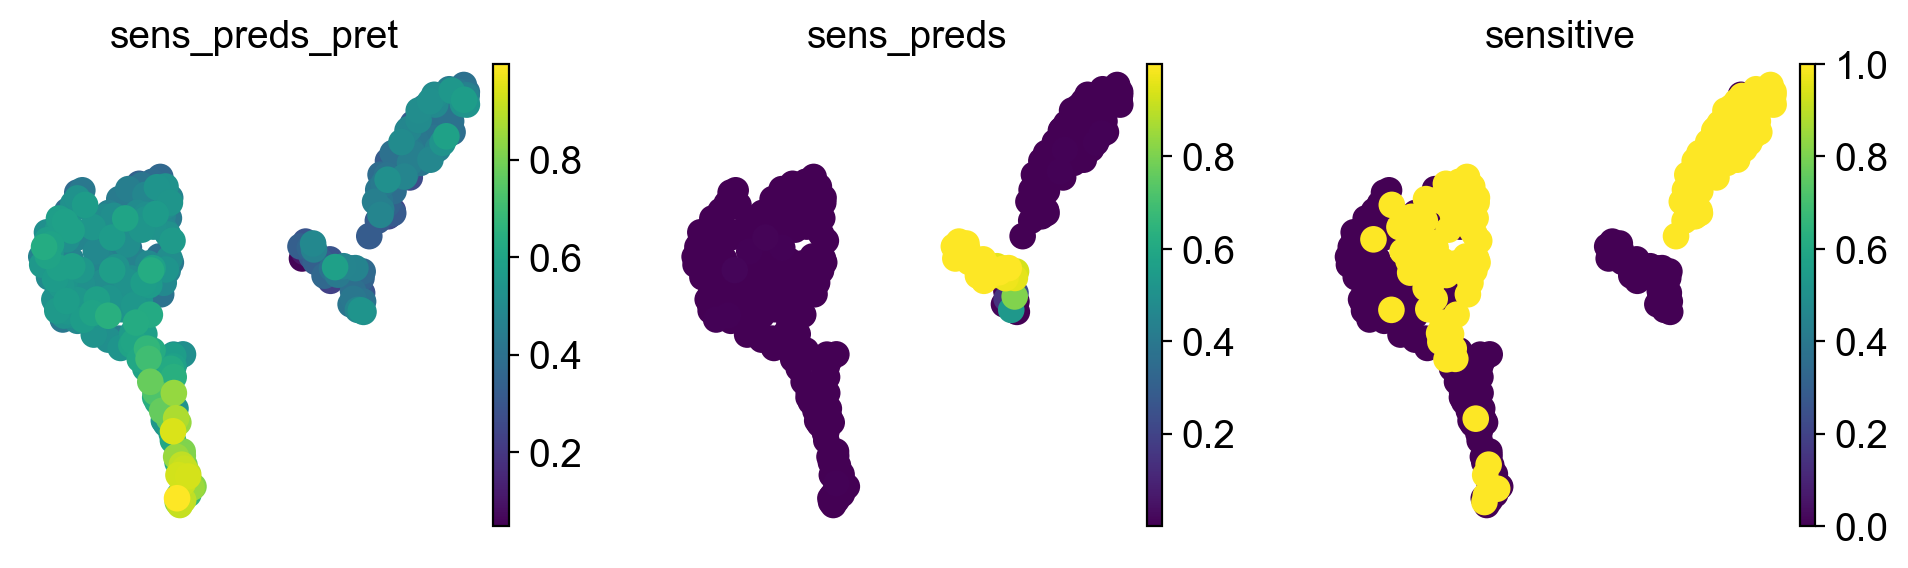

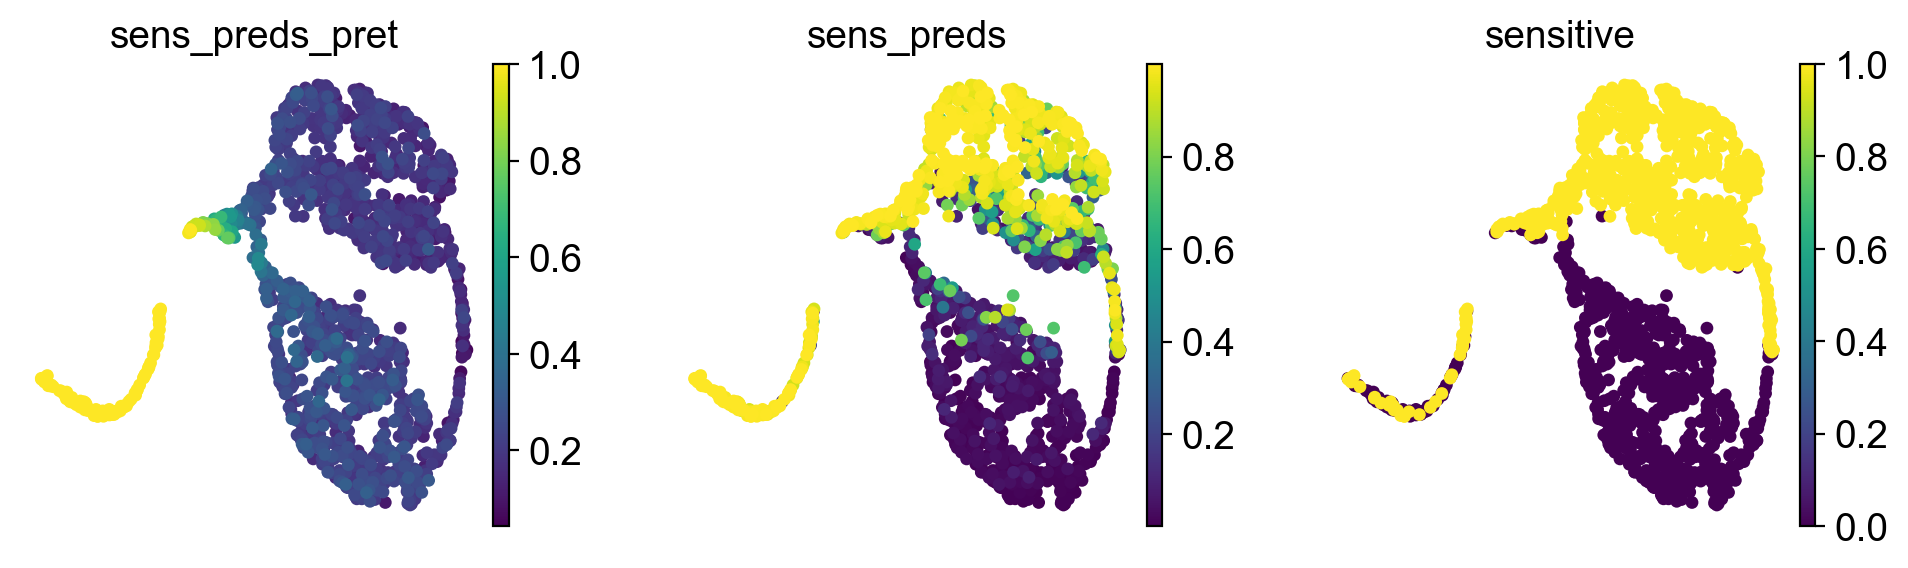

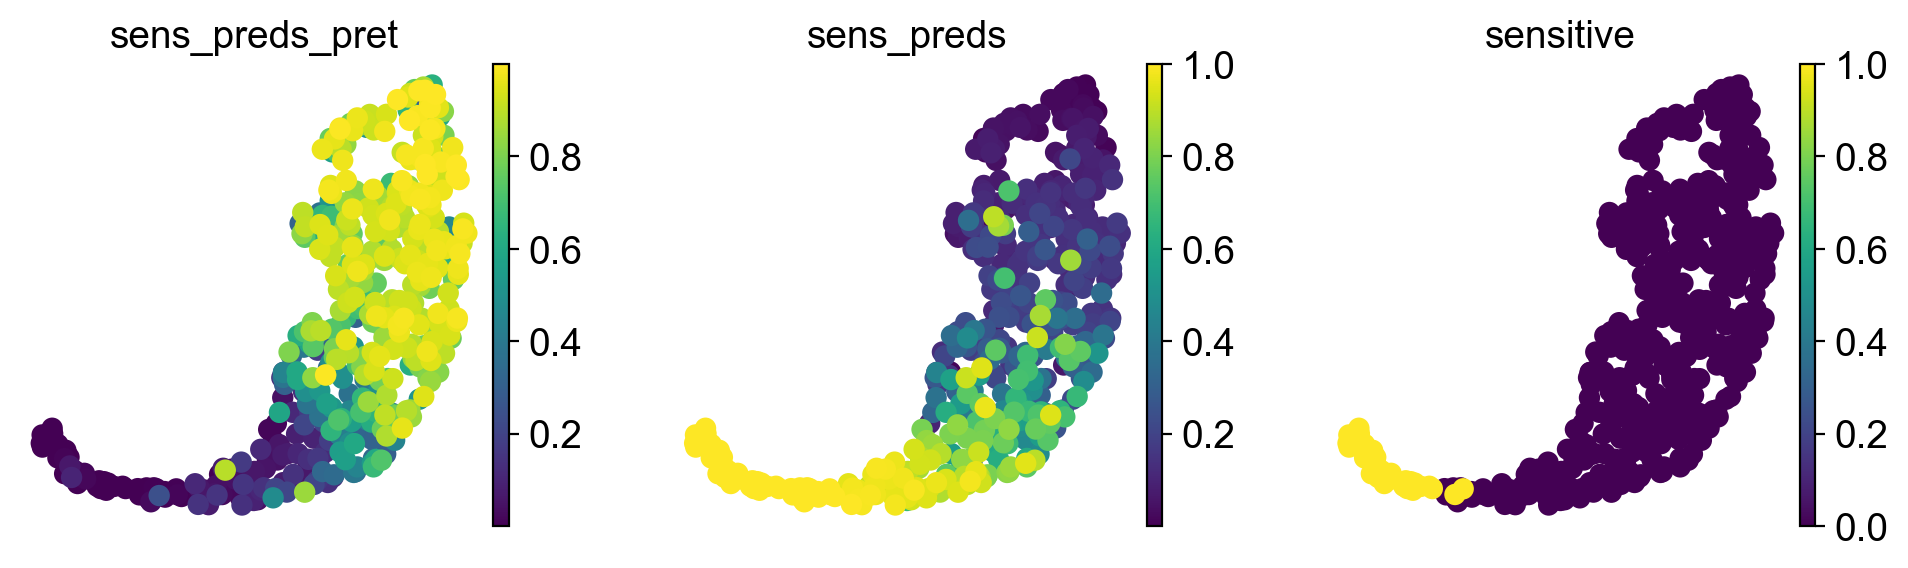

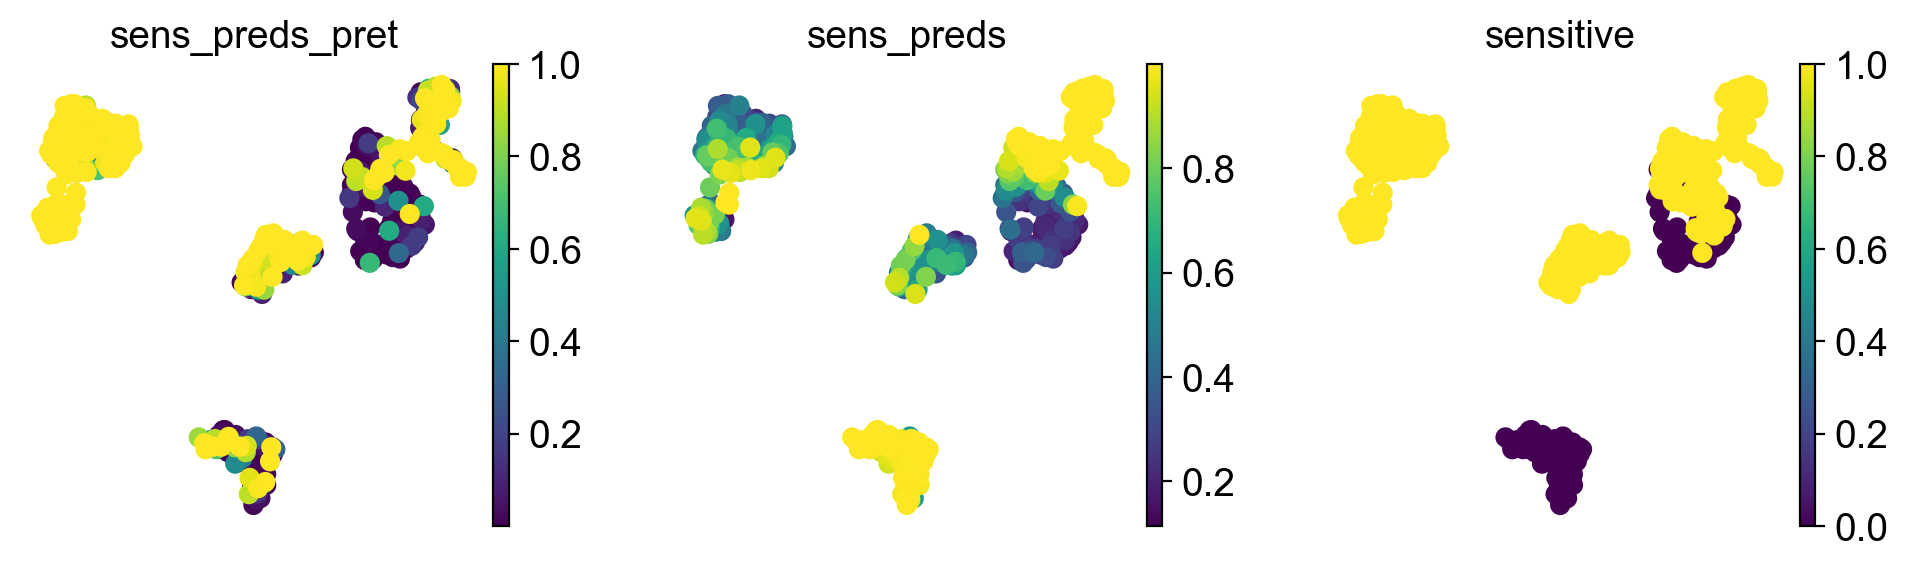

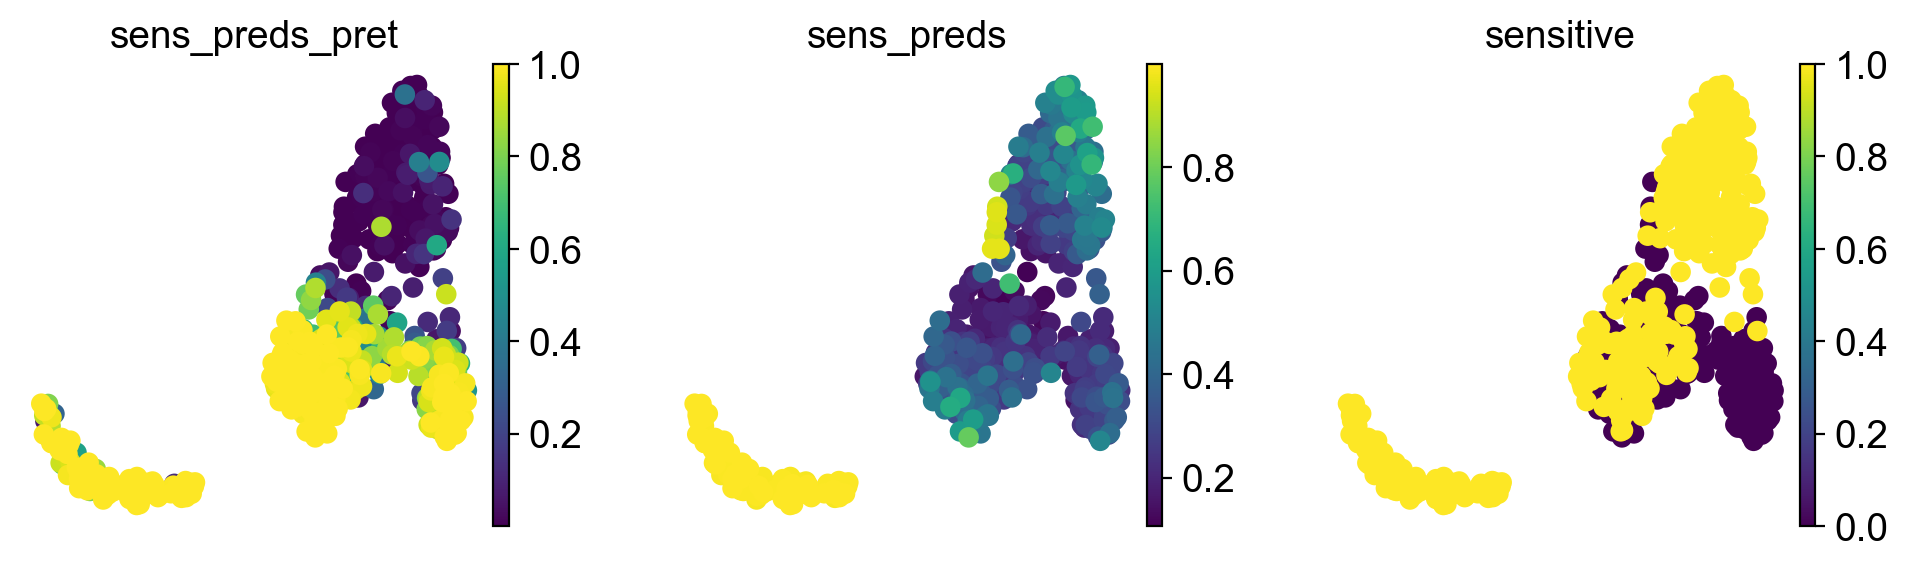

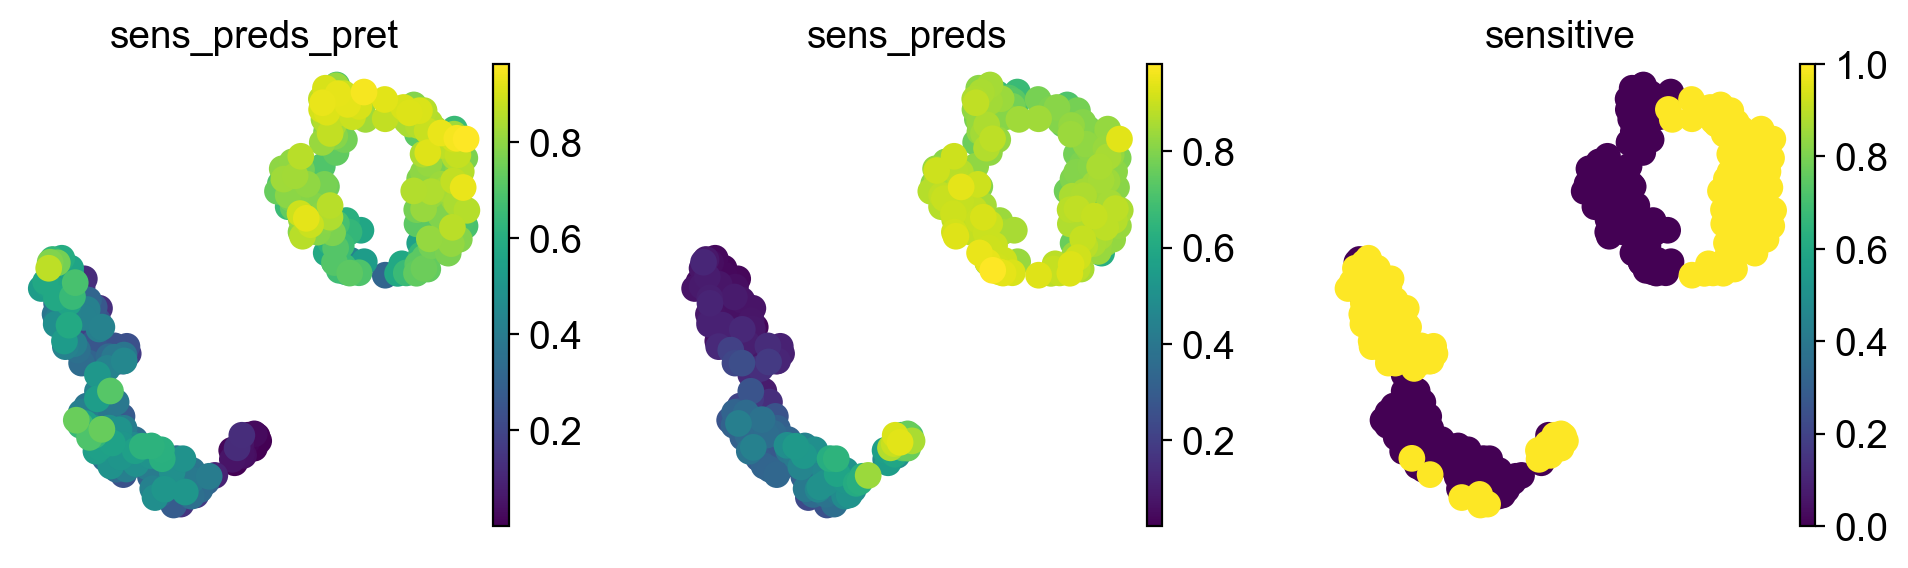

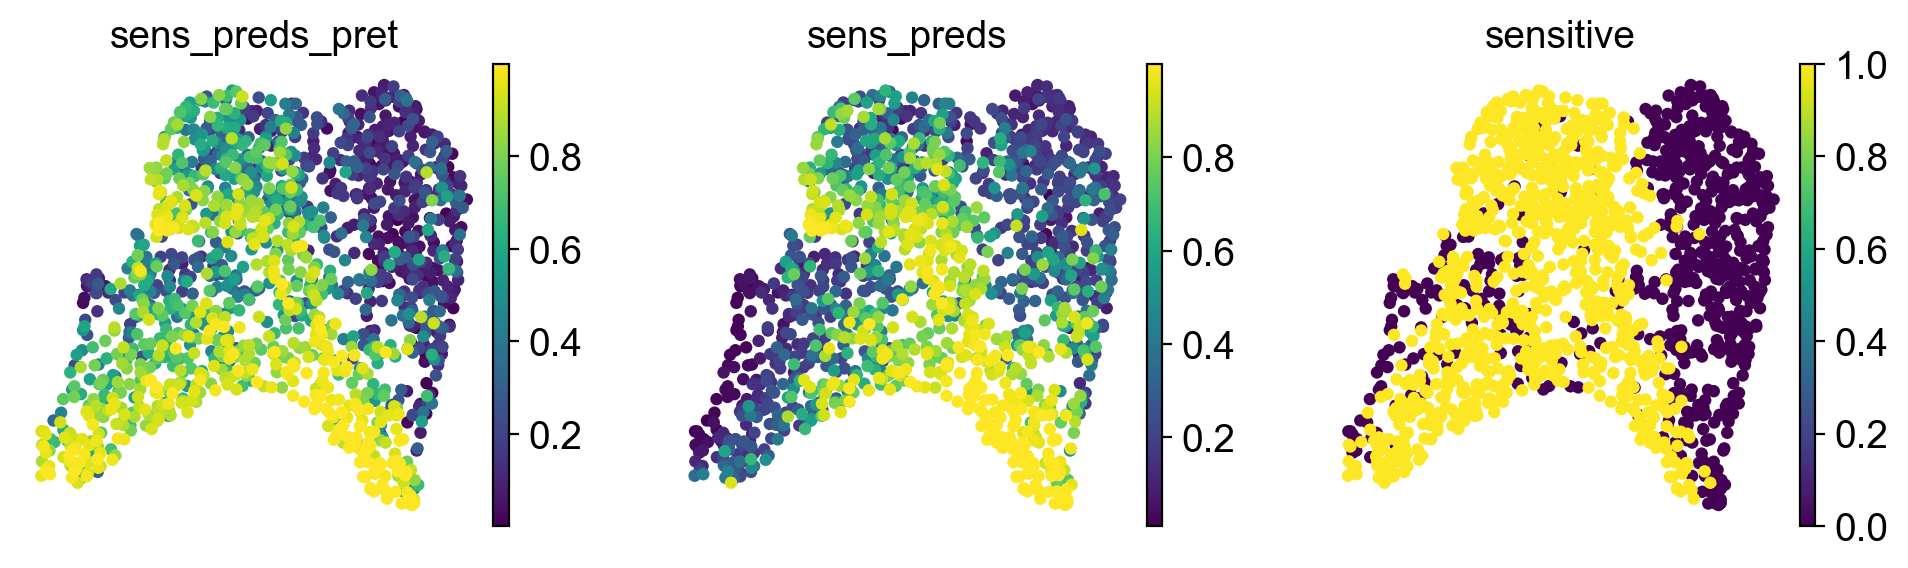

In [67]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)
for f in h5ad_list:
    adata = sc.read_h5ad(filename=f)
    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("\\")[1]
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.png')
    
    result.to_csv("saved/results/report_compare"+name + '.csv')



In [15]:
adata.obsm["X_umap"] = adata.obsm["X_umap_origin"]

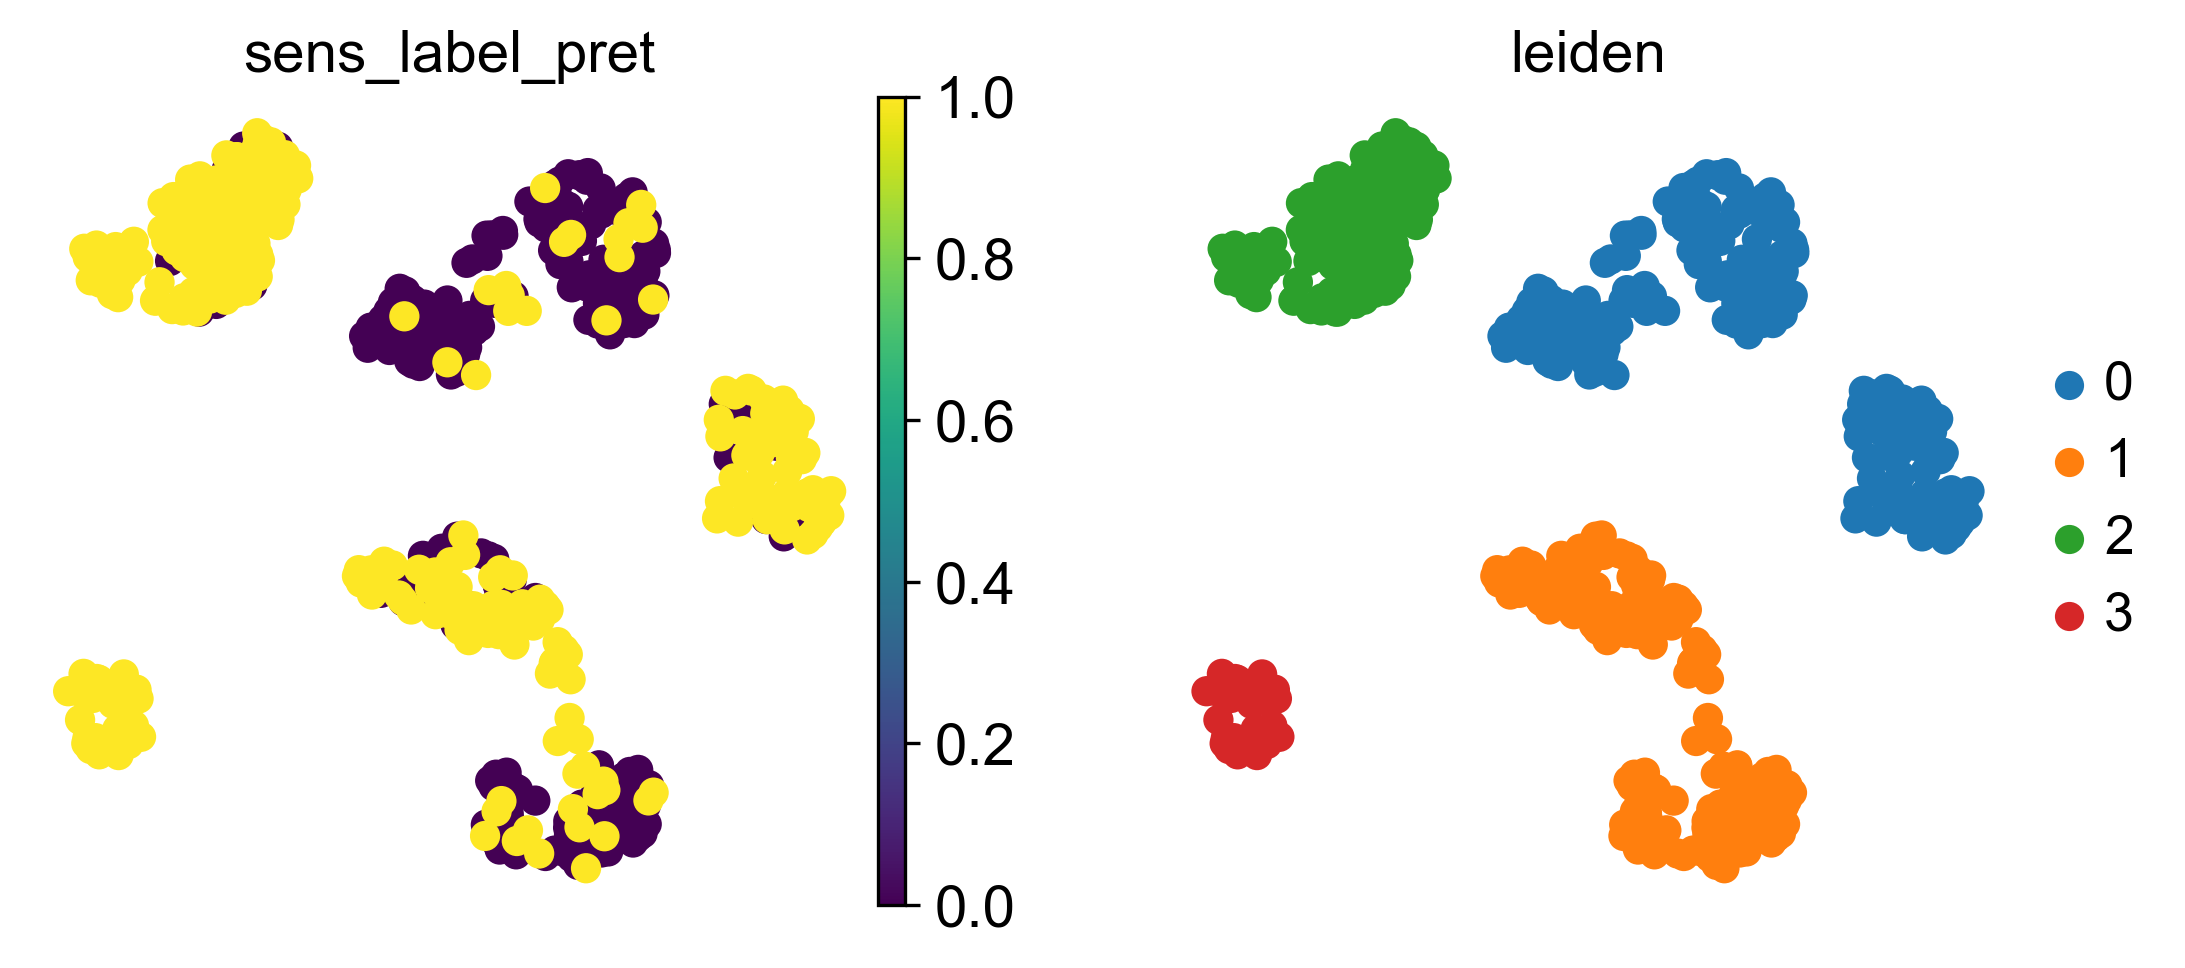

In [16]:
sc.pl.umap(adata,color=['sens_label_pret','leiden'])

In [17]:
sc.pp.neighbors(adata,use_rep='X_Trans',key_added="Trans")
sc.tl.umap(adata,neighbors_key="Trans")

computing neighbors


D:\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11004. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['Trans']`
    `.obsp['Trans_distances']`, distances for each pair of neighbors
    `.obsp['Trans_connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


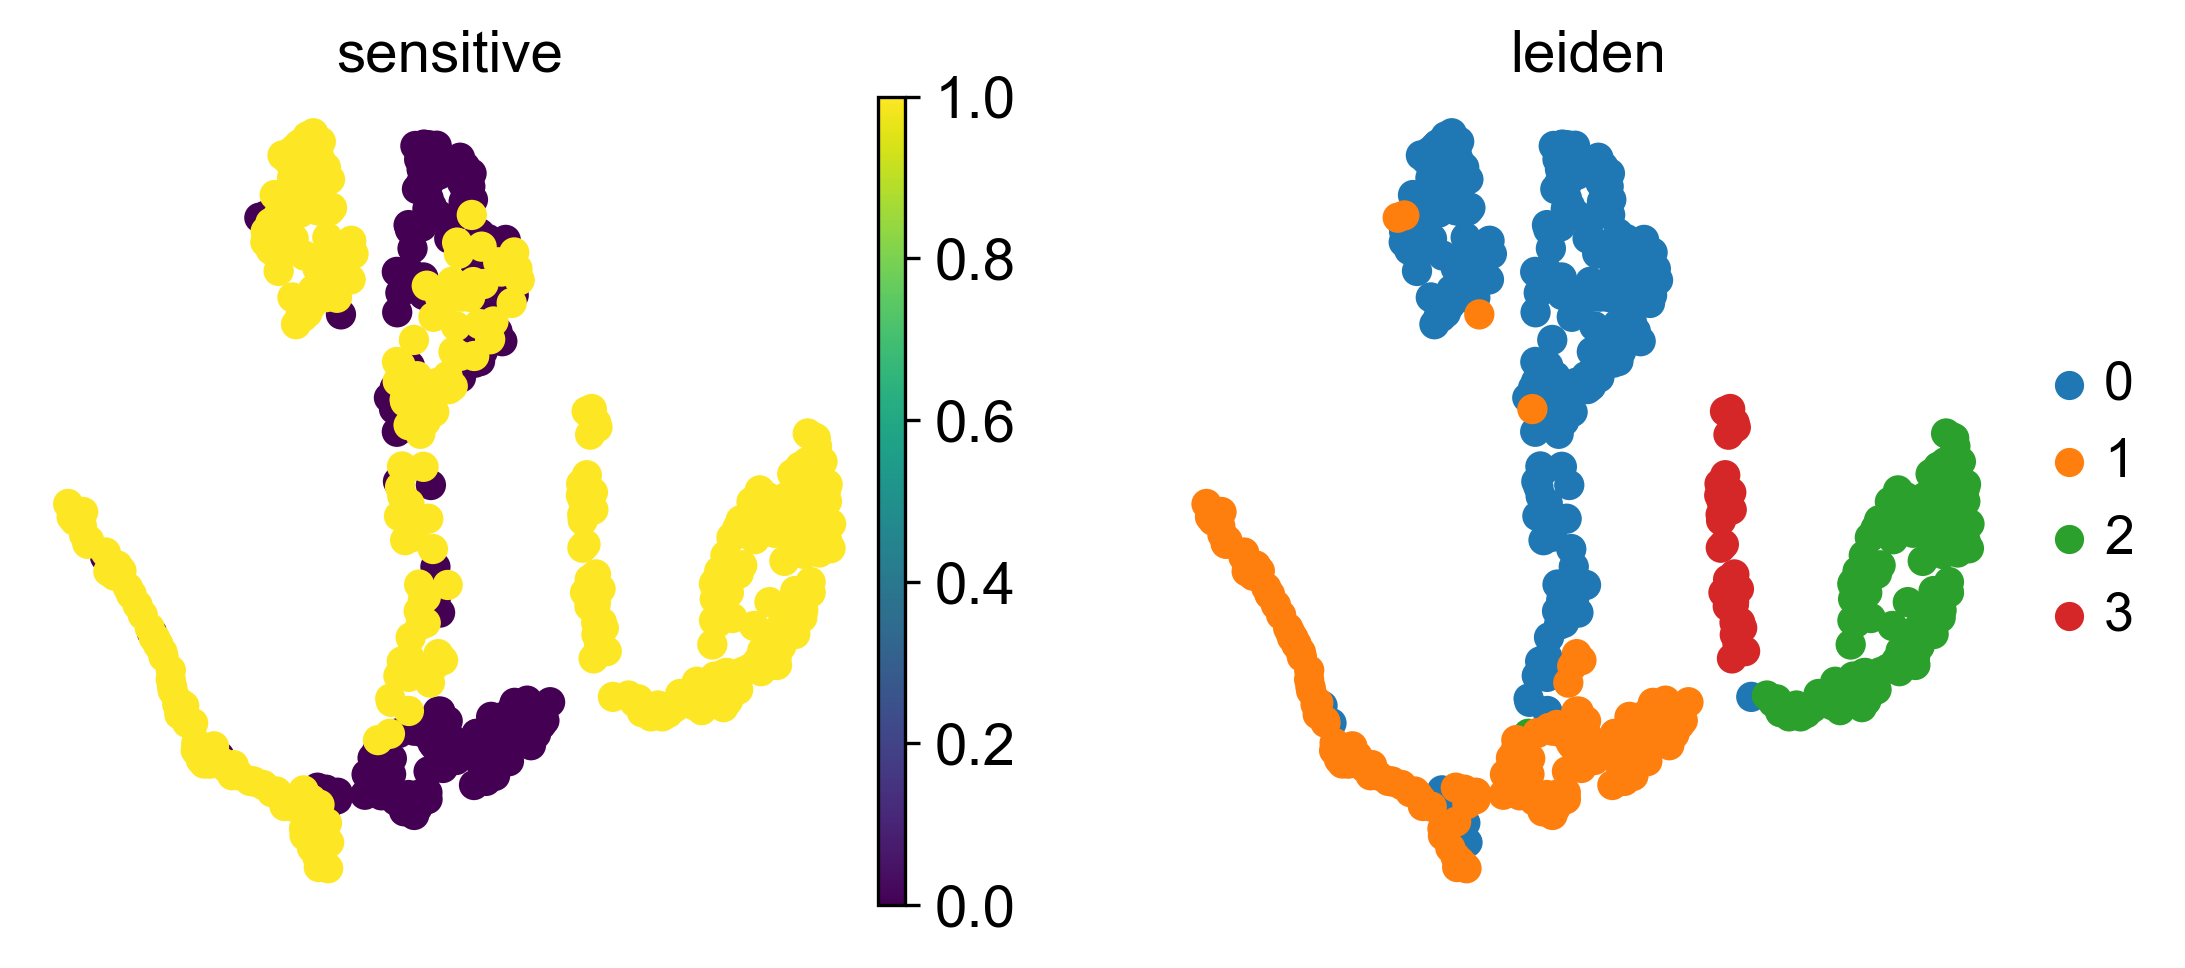

In [18]:
sc.pl.umap(adata,color=['sensitive','leiden'])